# Importing Libraries

In [116]:
import random
import csv
import hashlib
import urllib.request
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import requests
import zipfile
import glob
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# Dataset creation
Downloading the photos from Flickr and downloading the photos as a zip. <br>
The images are being downloaded via the FlickrAPI and stored in seperate folders for each class. In order to do that the user must create a public and secret key as described on the Flickr website https://www.flickr.com/services/apps/create/apply/. Add the new values to `FLICKR_PUBLIC` and `FLICKR_SECRET`<br>
The images are stored on GitHub - due to GitHub file size limitations we were only able to store a total of 100 MB. We decided to store around 5000 images with FlickrAPI size "s". <br>
In order to run the function the variable `download_new_photos` must be set to `True`. Additional keywords/classes can be introduced as well and the amount of photos to download can be changed in the variable `TOTAL_PHOTOS`

In [178]:
# set to False to not download new photos
download_new_photos = False

# the keywords to look photos for
keywords = ['sea', 'desert', 'mountain', 'river', 'forest']

# Function to download pictures from Flickr

def download_photos():

    # install and import FlickrAPI package
    !pip install flickrapi
    from flickrapi import FlickrAPI

    # Keys for flickr API
    FLICKR_PUBLIC = 'your_public_key'
    FLICKR_SECRET = 'your_secret_key'

    # Settings (extras = different resolution of photos)
    flickr = FlickrAPI(FLICKR_PUBLIC, FLICKR_SECRET, format='parsed-json')
    extras = 'url_s'

    # how many photos per category
    TOTAL_PHOTOS = 1000
    PHOTOS_PER_PAGE = 10

    cwd = os.getcwd()
    print(f'Photos will be stored at: {cwd}')

    temp_folder = 'photos/temp'

    # create photos directory
    try:
        os.mkdir('photos')
        print('Created folder photos')
        
    except:
        print('Folder "photos" already exists')

    # download the photos per keyword
    for word in keywords:
        # get all photos of the category
        page = 1
        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
        print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))

        # create subfolders
        try:
            os.mkdir('photos/'+word)
            print('Created folder ' + word)
        except:
            print(f'Folder "{word}" already exists')

        # download the photos
        j = 1 # index for filenames - won't be reset
        filename = ''
        batch = 1
        total_batch = int(TOTAL_PHOTOS/100)

        i = 0
        i_old = 0
      

        while j <= TOTAL_PHOTOS:
            
            while i == i_old:
                i = random.randint(1, PHOTOS_PER_PAGE-1)
                #print(f'index old: {i_old}, index new: {i}')
            i_old = i

            try:
                url = photos['photos']['photo'][i]['url_s']
                photo_id = photos['photos']['photo'][i]['id']
                #print(f'photo_id: {photo_id}')
            except:
                try:
                  error_photo = photos['photos']['photo'][i]
                  print(f'Error at {error_photo}')
                except:
                  print(f'Error')
                  pass

            try:
              os.mkdir(temp_folder)
            except:
              pass

            filename = 'photo_' + str(j) + '.jpg'
            directory = 'photos/' + word + "/" + filename
            directory_temp = temp_folder + "/" + filename
            urllib.request.urlretrieve(url, directory_temp)
            #print(f'Category {word}: Page {page}; Downloading {j} of {TOTAL_PHOTOS}')

            # create new csv file 
            f = open('hash_table.csv', 'a', newline='')
            f.close

            # get hash for comparison
            sha256_hash = hashlib.sha256()
            with open(directory_temp,"rb") as f:
                # Read and update hash string value in blocks of 4K
                for byte_block in iter(lambda: f.read(4096),b""):
                    sha256_hash.update(byte_block)
                hash_sha256 = sha256_hash.hexdigest()
                print(j, i, hash_sha256)

                # check if duplicate
                with open('hash_table.csv', 'r') as fp:
                    s = fp.read()

                if hash_sha256 not in s and photo_id not in s:
                    urllib.request.urlretrieve(url, directory)
                    #print(hash_sha256)
                    #print('no duplicate')
                    f = open('hash_table.csv', 'a', newline='')
                    writer = csv.writer(f)
                    row = [str(hash_sha256),photo_id]
                    writer.writerow(row)
                    f.close
                
                    if j % 100 == 0:
                        print(f'Batch {batch} of {total_batch} done')
                        batch += 1
                    j += 1

                    # reached end of page - reset i and increase page
                    if j % 3 == 0:
                        page += 1
                        print(f'Reached end of page; page {page-1} -> {page}')
                        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
                        #print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))

                else:
                    # duplicate found - go to next
                    page += 1
                    print(f'duplicate: image: {j} index: {i}, hash: {str(hash_sha256)}; page {page-1} -> {page}')
                    photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
                    #print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))
                
                # delete temp folder
                !rm -rf photos/temp
                

    print('Finished downloading the photos')
    
    # store all in zip and download
    print('Creating zip file and downloading it')
    !zip -r /content/photos/photos.zip /content/photos
    from google.colab import files
    files.download("/content/photos/photos.zip")

if download_new_photos:
    download_photos()

# Data Exploration
Retrieving the data from GitHub and retrieving example images of the dataset

In [118]:
# Download zip file from GitHub
url = 'https://github.com/amkobee/ADS/raw/main/photos.zip'
r = requests.get(url, allow_redirects=True)

open('photos.zip', 'wb').write(r.content)

# Unzip the file
with zipfile.ZipFile('photos.zip', 'r') as zip_ref:
    zip_ref.extractall()            # folder named "content" will be created

In [119]:
# get the amount of photos
data_dir = '/content/photos/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6073


In [120]:
# create a dataset containing all information

batch_size = 32
img_height = 180
img_width = 180

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get the class names from the folder names
class_names = full_ds.class_names
print(class_names)

Found 6073 files belonging to 5 classes.
['beach', 'desert', 'forest', 'mountains', 'river']


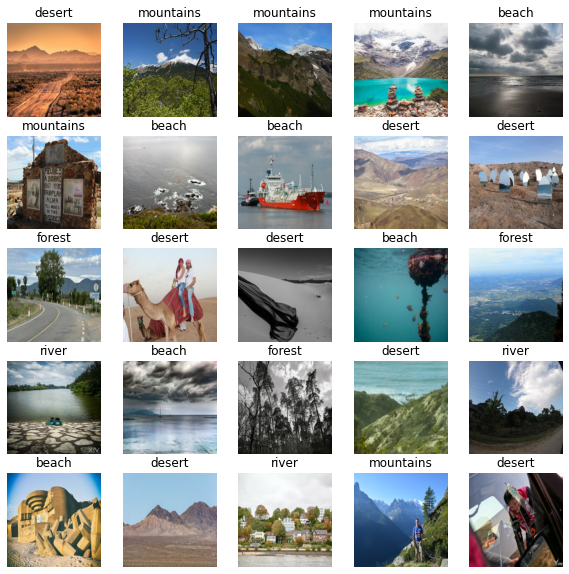

In [121]:
# print some example images
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Result Discussion

Retrieving the images from a platform where everyone can upload their on images with own tags and descriptions can lead to bad data for our model. <br>
In order to mitigate that risk we introduced randomnes to our fetching function. <br>
With that we want to avoid bad data on one handside on the other we don't want to use mulitple pictures of the same object/landscape uploaded by the same user.

# Data Preparation

In [122]:
# split in training and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6073 files belonging to 5 classes.
Using 5466 files for training.
Found 6073 files belonging to 5 classes.
Using 607 files for validation.


In [123]:
# set amount of classes to amount of keywords
num_classes = len(keywords)

## Result Visualization Function

In [169]:
# function to visualize training results

def visualize_result():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def visualize_resnet():
  acc = history['accuracy']
  val_acc = history['val_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Model Creation and Training

Below we will show different iterations of our models <br>
The first model shows our initial setup. The following will show all the modifications that were made during the process

## First training

In [125]:
# define the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_20 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 22, 22, 64)      

In [126]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
)

# save the model
model.save('landscape_classifier_v1.h5')

Epoch 1/10
171/171 [==============================] - 9s 51ms/step - loss: 1.3537 - accuracy: 0.4329 - val_loss: 1.2514 - val_accuracy: 0.4811
Epoch 2/10
171/171 [==============================] - 8s 45ms/step - loss: 1.2423 - accuracy: 0.4901 - val_loss: 1.2261 - val_accuracy: 0.4909
Epoch 3/10
171/171 [==============================] - 8s 48ms/step - loss: 1.1639 - accuracy: 0.5304 - val_loss: 1.2311 - val_accuracy: 0.5008
Epoch 4/10
171/171 [==============================] - 8s 45ms/step - loss: 1.0695 - accuracy: 0.5739 - val_loss: 1.2182 - val_accuracy: 0.5189
Epoch 5/10
171/171 [==============================] - 8s 47ms/step - loss: 0.9314 - accuracy: 0.6314 - val_loss: 1.3276 - val_accuracy: 0.5124
Epoch 6/10
171/171 [==============================] - 8s 48ms/step - loss: 0.7671 - accuracy: 0.7109 - val_loss: 1.4046 - val_accuracy: 0.5189
Epoch 7/10
171/171 [==============================] - 8s 46ms/step - loss: 0.5536 - accuracy: 0.8008 - val_loss: 1.5895 - val_accuracy: 0.4876

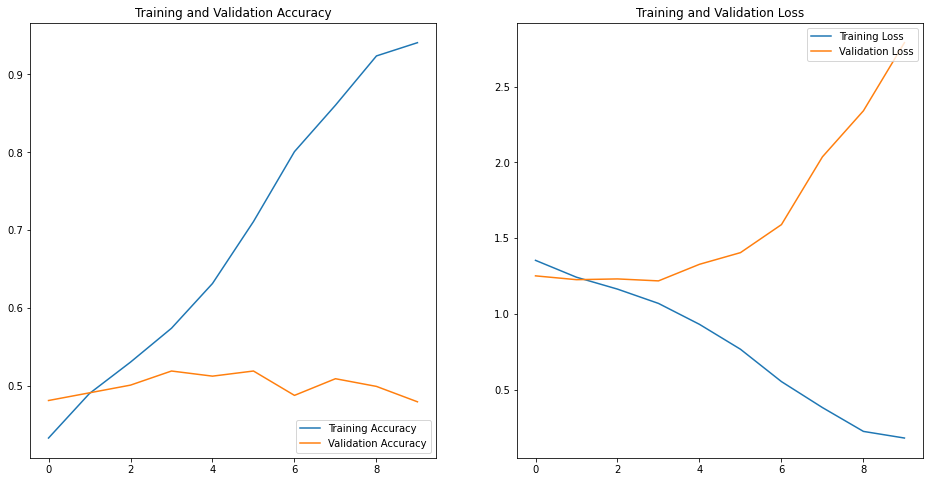

In [127]:
# visualize result
visualize_result()

### Result Discussion

For the first model the result is quite acceptable. The accuracy for the training set is extremly high but only around 50% for the validation set. This indicates overfitting which we will tackle in the next model version. Additionally the difference in loss is extremely high compared to the training data set <br>
In order to improve the result for the validation data set we'll introduce **dropout, regularization** and **data augmentation** to the model in the next iteration in order to avoid overfitting.

## Second training

Added dropout and regularization to the model

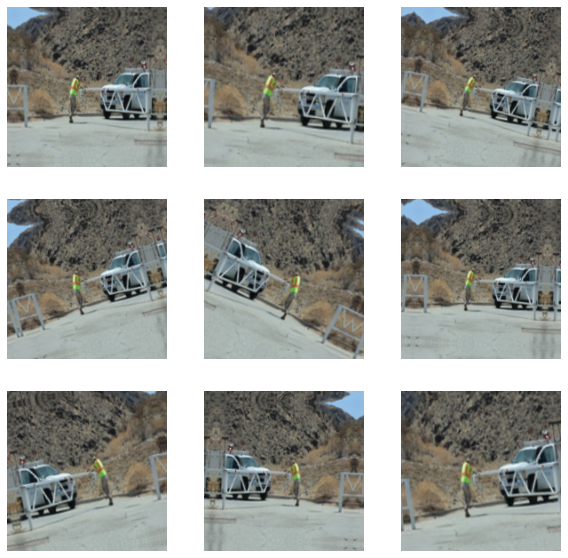

In [130]:
# data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomRotation(0.1),
  ]
)

# print an example
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [131]:
# define the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_21 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 45, 45, 64)      

In [132]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

# save the model
model.save('landscape_classifier_v2.h5')

Epoch 1/20
171/171 [==============================] - 9s 48ms/step - loss: 1.7943 - accuracy: 0.3529 - val_loss: 1.4086 - val_accuracy: 0.4662
Epoch 2/20
171/171 [==============================] - 8s 47ms/step - loss: 1.3924 - accuracy: 0.4512 - val_loss: 1.3437 - val_accuracy: 0.4909
Epoch 3/20
171/171 [==============================] - 8s 47ms/step - loss: 1.3714 - accuracy: 0.4565 - val_loss: 1.3292 - val_accuracy: 0.4893
Epoch 4/20
171/171 [==============================] - 8s 48ms/step - loss: 1.3458 - accuracy: 0.4641 - val_loss: 1.4220 - val_accuracy: 0.4465
Epoch 5/20
171/171 [==============================] - 8s 47ms/step - loss: 1.3417 - accuracy: 0.4662 - val_loss: 1.2922 - val_accuracy: 0.5041
Epoch 6/20
171/171 [==============================] - 8s 46ms/step - loss: 1.3179 - accuracy: 0.4760 - val_loss: 1.3584 - val_accuracy: 0.4860
Epoch 7/20
171/171 [==============================] - 8s 47ms/step - loss: 1.3207 - accuracy: 0.4718 - val_loss: 1.2882 - val_accuracy: 0.5157

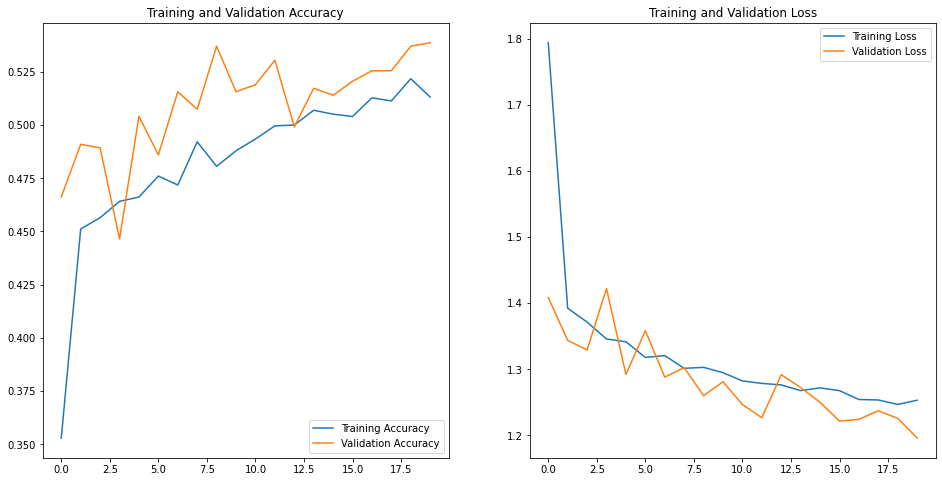

In [133]:
# visualize result
visualize_result()

### Result Discussion

We were able to reduce the overfitting by introducing dropout, data augmentation and regularization. <br>
We were able to even increase the validation accuracy a little bit. In the next model iteration we would like to increase accuracy by add more layers.

## Model testing

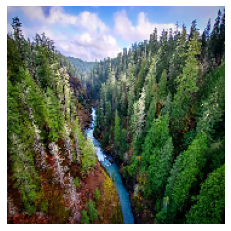

This image most likely belongs to river with a 47.77 percent confidence.
********************************************


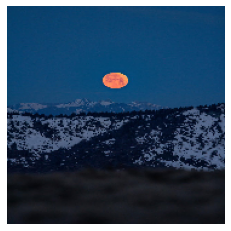

This image most likely belongs to river with a 32.68 percent confidence.
********************************************


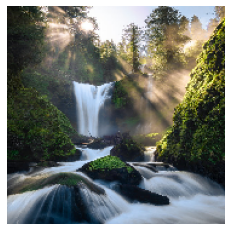

This image most likely belongs to river with a 70.06 percent confidence.
********************************************


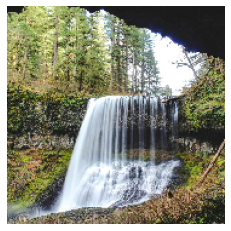

This image most likely belongs to forest with a 65.60 percent confidence.
********************************************


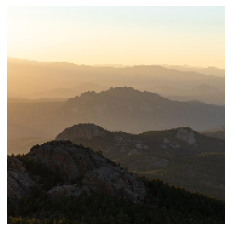

This image most likely belongs to mountains with a 37.20 percent confidence.
********************************************


In [134]:
# load the images
img_amount = 5
i = 1

while i <= img_amount:
    try:
        images_path = f'https://github.com/amkobee/ADS/raw/main/scraped_images/test_{i}.png'
        test_image_path = tf.keras.utils.get_file(f'test_{i}.png', origin=images_path)
    except:
        break

    img = keras.preprocessing.image.load_img(
        test_image_path, target_size=(img_height, img_width)
    )

    # print the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('********************************************')

    i+=1


## Third Training
Added more layers

In [135]:
# define the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_22 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 90, 90, 16)        2320      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 45, 45, 16)      

In [136]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

# save the model
model.save('landscape_classifier_v3.h5')

Epoch 1/20
171/171 [==============================] - 11s 58ms/step - loss: 1.7684 - accuracy: 0.2947 - val_loss: 1.4883 - val_accuracy: 0.3806
Epoch 2/20
171/171 [==============================] - 8s 47ms/step - loss: 1.4485 - accuracy: 0.3611 - val_loss: 1.4002 - val_accuracy: 0.4069
Epoch 3/20
171/171 [==============================] - 9s 52ms/step - loss: 1.4021 - accuracy: 0.3824 - val_loss: 1.3627 - val_accuracy: 0.4086
Epoch 4/20
171/171 [==============================] - 9s 51ms/step - loss: 1.3706 - accuracy: 0.3921 - val_loss: 1.3532 - val_accuracy: 0.4185
Epoch 5/20
171/171 [==============================] - 9s 50ms/step - loss: 1.3733 - accuracy: 0.3966 - val_loss: 1.3753 - val_accuracy: 0.3839
Epoch 6/20
171/171 [==============================] - 9s 51ms/step - loss: 1.3597 - accuracy: 0.4074 - val_loss: 1.3386 - val_accuracy: 0.4267
Epoch 7/20
171/171 [==============================] - 9s 49ms/step - loss: 1.3400 - accuracy: 0.4396 - val_loss: 1.3320 - val_accuracy: 0.444

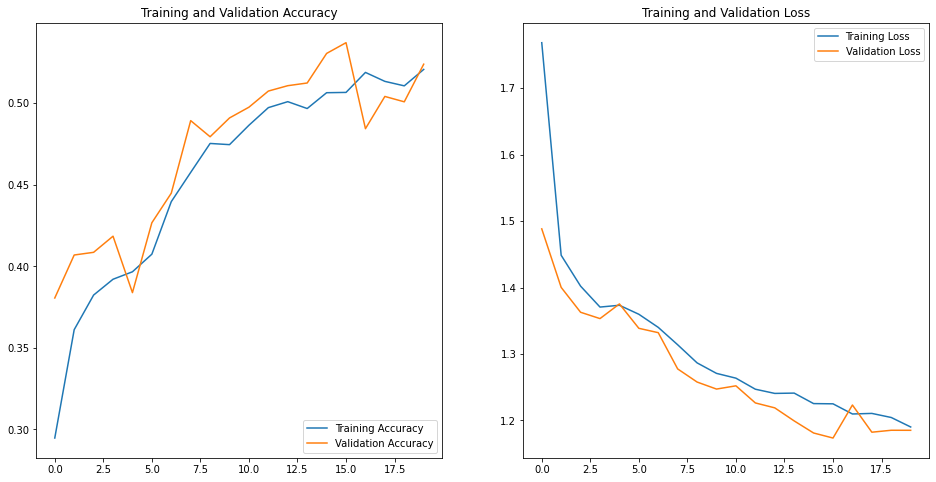

In [137]:
# visualize result
visualize_result()

### Result Discussion

We were not able to increase the accuracy significantly. In order to improve our model we would probably need to introduce recurrency. <br>
That's why we will use the ResNet V2 50 as our next model to train. <br>
We would like to compare our own model with a state of the art model.

## Model testing

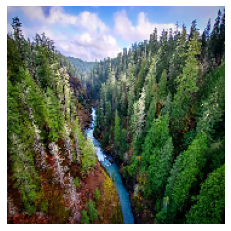

This image most likely belongs to forest with a 71.09 percent confidence.
********************************************


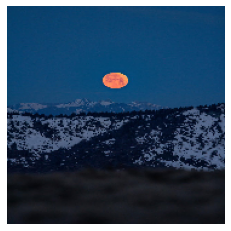

This image most likely belongs to sea with a 36.54 percent confidence.
********************************************


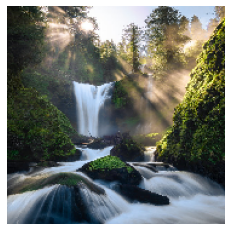

This image most likely belongs to river with a 68.85 percent confidence.
********************************************


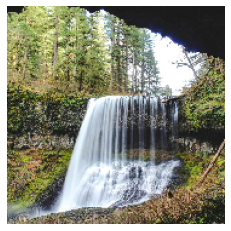

This image most likely belongs to forest with a 87.34 percent confidence.
********************************************


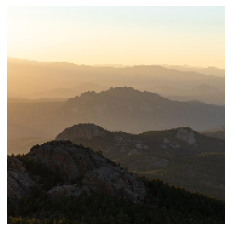

This image most likely belongs to mountain with a 44.34 percent confidence.
********************************************


In [ ]:
# load the images
img_amount = 5
i = 1

while i <= img_amount:
    try:
        images_path = f'https://github.com/amkobee/ADS/raw/main/scraped_images/test_{i}.png'
        test_image_path = tf.keras.utils.get_file(f'test_{i}.png', origin=images_path)
    except:
        break

    img = keras.preprocessing.image.load_img(
        test_image_path, target_size=(img_height, img_width)
    )

    # print the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('********************************************')

    i+=1


## Comparison with ResNet V2 50

In [163]:
model_name = "resnet_v2_50" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 180)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
Input size (180, 180)


In [164]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20, horizontal_flip=True, zoom_range=0.5)# add data augmentation trasnformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set

train_generator = train_datagen.flow_from_directory(
    '/content/photos/', subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_generator = valid_datagen.flow_from_directory(
    '/content/photos/', subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

Found 4861 images belonging to 5 classes.
Found 1212 images belonging to 5 classes.


In [165]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

In [166]:
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_41 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [167]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [168]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
151/151 [==============================] - 45s 280ms/step - loss: 1.4185 - accuracy: 0.5214 - val_loss: 1.1484 - val_accuracy: 0.6478
Epoch 2/10
151/151 [==============================] - 42s 275ms/step - loss: 1.1753 - accuracy: 0.6250 - val_loss: 1.1234 - val_accuracy: 0.6639
Epoch 3/10
151/151 [==============================] - 42s 278ms/step - loss: 1.1508 - accuracy: 0.6304 - val_loss: 1.1764 - val_accuracy: 0.6326
Epoch 4/10
151/151 [==============================] - 42s 276ms/step - loss: 1.0744 - accuracy: 0.6656 - val_loss: 1.1186 - val_accuracy: 0.6571
Epoch 5/10
151/151 [==============================] - 42s 276ms/step - loss: 1.0730 - accuracy: 0.6689 - val_loss: 1.1449 - val_accuracy: 0.6512
Epoch 6/10
151/151 [==============================] - 42s 276ms/step - loss: 1.0556 - accuracy: 0.6720 - val_loss: 1.1143 - val_accuracy: 0.6571
Epoch 7/10
151/151 [==============================] - 42s 276ms/step - loss: 1.0541 - accuracy: 0.6767 - val_loss: 1.1032 - val_ac

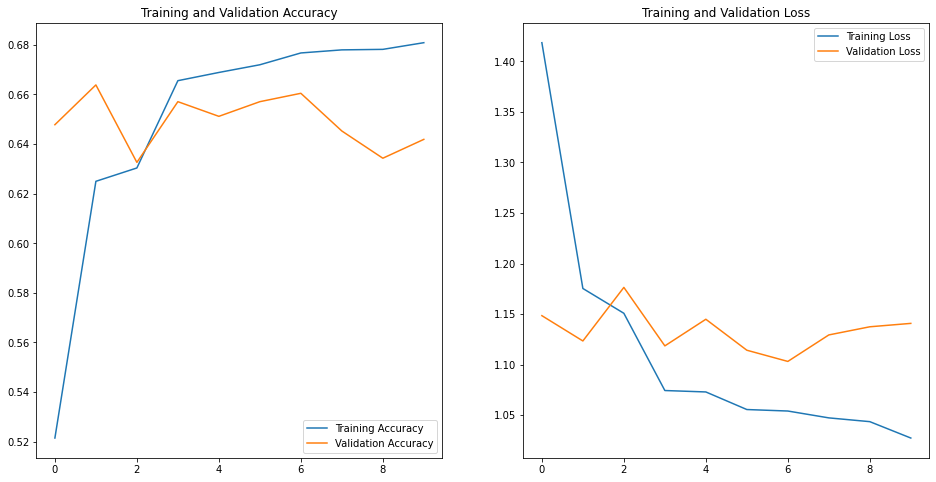

In [171]:
# visualize result
visualize_resnet()

### Result Discussion
The ResNet V2 50 model outperforms our model by approx. 10-15% in accuracy. <br>
This was the result we also expected from the beginning. Also this is the ResNet vesion which uses only a third of the model's layers. <br>
In the next iteration we'd like to train the full ResNet model with our data to see how much of a difference there is.

## Comparison with ResNet V2 152

In [172]:
model_name = "resnet_v2_152" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 180)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20, horizontal_flip=True, zoom_range=0.5)# add data augmentation trasnformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set

train_generator = train_datagen.flow_from_directory(
    '/content/photos/', subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_generator = valid_datagen.flow_from_directory(
    '/content/photos/', subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

Selected model: resnet_v2_152 : https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4
Input size (180, 180)
Found 4861 images belonging to 5 classes.
Found 1212 images belonging to 5 classes.
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 2048)              58331648  
_________________________________________________________________
dropout_42 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 10245     
Total params: 58,341,893
Trainable params: 10,245
Non-trainable params: 58,331,648
_________________________________________________________________


In [173]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
151/151 [==============================] - 61s 345ms/step - loss: 1.3954 - accuracy: 0.5200 - val_loss: 1.1868 - val_accuracy: 0.6098
Epoch 2/10
151/151 [==============================] - 51s 335ms/step - loss: 1.1533 - accuracy: 0.6422 - val_loss: 1.0952 - val_accuracy: 0.6546
Epoch 3/10
151/151 [==============================] - 51s 335ms/step - loss: 1.1032 - accuracy: 0.6536 - val_loss: 1.1182 - val_accuracy: 0.6486
Epoch 4/10
151/151 [==============================] - 51s 336ms/step - loss: 1.0852 - accuracy: 0.6651 - val_loss: 1.1000 - val_accuracy: 0.6512
Epoch 5/10
151/151 [==============================] - 51s 336ms/step - loss: 1.0549 - accuracy: 0.6763 - val_loss: 1.0936 - val_accuracy: 0.6579
Epoch 6/10
151/151 [==============================] - 51s 336ms/step - loss: 1.0301 - accuracy: 0.6904 - val_loss: 1.1063 - val_accuracy: 0.6546
Epoch 7/10
151/151 [==============================] - 51s 337ms/step - loss: 1.0419 - accuracy: 0.6796 - val_loss: 1.0993 - val_ac

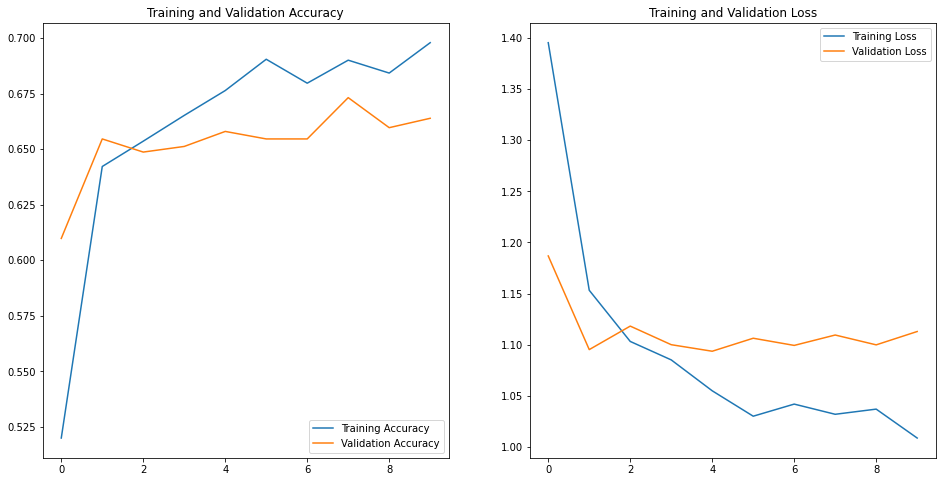

In [174]:
# visualize result
visualize_resnet()

### Result Discussion
The ResNet V2 152 model performs similar to the 50 layers model.<br>
We assume that this model would only be benefitial if we had at least 10000 photos to train the model. <br>
In order to get all the benefits of the full model we would recommend to train the model locally on GPU, where there are also no limitations mit file storage. Unfortunately none of us owns a computer with a high-end GPU.

# Conclusion
In our projet we face two main challanges:<br>
**Data Quality**<br>
We decided to retrieve our images via the Flickr API because it enabled us unlimited amount of images. Hence, we used images which were uploaded by people all around the world and they classified the images by their own. <br>
This leads us to bad data quality. There are a lot of images which could be classified by another person differently. In order to mitigate that challange we manually removed in our opinion wrongfully tagged images to have a cleaner dataset.

**Data Quantity**<br>
In order to be able to properly train a convolutional neural network we would need much more than only a little over 6000 images. <br>
Due to limitations we faced with the maximum storage size on GitHub we could not use more thant that.<br>
Nevertheless, we are happy with the result.

# Ethical Discussion


*   Image recognition can be used for good and bad purpose
*   In the case that we have shown the image recognition is used for a harmless purpose
*   However, if the algo would be improved and enriched with other data he could potentially recognize different faces with a certain accuracy
*   In combination with weapons in particular drones could autonomous kill defined people based on accuracy of an algo, which may lead to the question who takes the responsibilty
* The question then may be if we should even program such algos?
*   On the other hand this algo could be trained for skin cancer detection 
*   Thus, the question is not that easy to answer
*   We as a group think it is important whenever you train a new algo to ask yourself how high is the risk of this algo or AI when it is used?
*   The higher you assess that risk the higher standard in regards to ethics you should set and think about already when designbing such an algo or AI application



